<a href="https://colab.research.google.com/github/btcnhung1299/tf-practice/blob/master/TXT_SarcasmDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Data Gathering

In [2]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json

--2020-09-29 12:49:35--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 173.194.203.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json.4’

sarcasm.json.4      100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2020-09-29 12:49:35 (214 MB/s) - ‘sarcasm.json.4’ saved [5643545/5643545]



In [3]:
df = pd.read_json("./sarcasm.json")
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


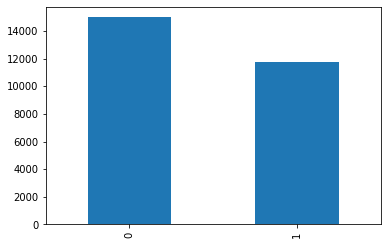

In [4]:
df["is_sarcastic"].value_counts().plot(kind="bar");

In [5]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2)

In [6]:
get_samples = lambda df : (df["headline"].values, df["is_sarcastic"].values)
train_data, train_labels = get_samples(train_df)
val_data, val_labels = get_samples(val_df)

## Data Tokenization & Batchifying

### Tokenization

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
VOCAB_SIZE = 10000
tokenizer = Tokenizer(VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data)

### Create samples

In [9]:
pd.Series(train_data).apply(lambda x : len(x)).describe()

count    21367.000000
mean        60.897927
std         19.275282
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
dtype: float64

In [10]:
MAX_SEQ_LEN = 128
BUFFER_SIZE = 1024
BATCH_SIZE = 64

def create_tfds(tokenizer, X, y, padding=False):
  if padding:
    X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_SEQ_LEN, padding="post")
  return tf.data.Dataset.from_tensor_slices((X, y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

ds_train = create_tfds(tokenizer, train_data, train_labels, padding=True)
ds_val = create_tfds(tokenizer, val_data, val_labels, padding=True)

## Model Architecture

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, GlobalAveragePooling1D, Dense

EMBED_DIM = 64

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="swish"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 644,225
Trainable params: 644,225
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [13]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7)
model.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[callbacks]);

Epoch 1/20
334/334 [==============================] - 2s 7ms/step - loss: 0.6731 - acc: 0.5682 - val_loss: 0.6311 - val_acc: 0.6221
Epoch 2/20
334/334 [==============================] - 2s 7ms/step - loss: 0.5157 - acc: 0.7784 - val_loss: 0.4368 - val_acc: 0.7980
Epoch 3/20
334/334 [==============================] - 2s 7ms/step - loss: 0.3800 - acc: 0.8352 - val_loss: 0.3666 - val_acc: 0.8424
Epoch 4/20
334/334 [==============================] - 2s 7ms/step - loss: 0.3310 - acc: 0.8607 - val_loss: 0.3491 - val_acc: 0.8512
Epoch 5/20
334/334 [==============================] - 2s 7ms/step - loss: 0.3027 - acc: 0.8740 - val_loss: 0.3347 - val_acc: 0.8575
Epoch 6/20
334/334 [==============================] - 2s 7ms/step - loss: 0.2840 - acc: 0.8815 - val_loss: 0.3452 - val_acc: 0.8508
Epoch 7/20
334/334 [==============================] - 2s 7ms/step - loss: 0.2688 - acc: 0.8905 - val_loss: 0.3666 - val_acc: 0.8401
Epoch 8/20
334/334 [==============================] - 2s 7ms/step - loss: 0.

In [14]:
model.evaluate(ds_val)

84/84 [==============================] - 0s 2ms/step - loss: 0.3353 - acc: 0.8652


[0.3352658450603485, 0.865218997001648]

### RNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dropout, Dense, SpatialDropout1D

EMBED_DIM = 64

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(32, activation="swish"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))

In [16]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49920     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 768,577
Trainable params: 768,577
Non-trainable params: 0
________________________________________________

In [17]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)
model.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[callbacks]);

Epoch 1/20
334/334 [==============================] - 12s 35ms/step - loss: 0.4014 - acc: 0.8117 - val_loss: 0.3129 - val_acc: 0.8656
Epoch 2/20
334/334 [==============================] - 10s 31ms/step - loss: 0.2520 - acc: 0.8969 - val_loss: 0.3036 - val_acc: 0.8701
Epoch 3/20
334/334 [==============================] - 10s 31ms/step - loss: 0.2044 - acc: 0.9195 - val_loss: 0.3073 - val_acc: 0.8738
Epoch 4/20
334/334 [==============================] - 10s 31ms/step - loss: 0.1728 - acc: 0.9333 - val_loss: 0.3357 - val_acc: 0.8688
Epoch 5/20
334/334 [==============================] - 10s 31ms/step - loss: 0.1478 - acc: 0.9454 - val_loss: 0.3608 - val_acc: 0.8609
Epoch 6/20
334/334 [==============================] - 10s 30ms/step - loss: 0.1245 - acc: 0.9553 - val_loss: 0.4131 - val_acc: 0.8579


In [18]:
model.evaluate(ds_val)

84/84 [==============================] - 1s 12ms/step - loss: 0.4131 - acc: 0.8579


[0.4130658209323883, 0.857918381690979]

### Transfer learning w. pretrained embedding

In [19]:
ds_train = create_tfds(tokenizer, train_data, train_labels, padding=False)
ds_val = create_tfds(tokenizer, val_data, val_labels, padding=False)

In [20]:
import tensorflow_hub as hub
embedding_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

model = Sequential()
model.add(hub.KerasLayer(embedding_url, input_shape=(), dtype=tf.string, trainable=True))
model.add(Dense(64, activation="swish"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [22]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
model.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[callbacks]);

Epoch 1/20
334/334 [==============================] - 24s 72ms/step - loss: 0.3984 - acc: 0.8191 - val_loss: 0.3126 - val_acc: 0.8647
Epoch 2/20
334/334 [==============================] - 24s 71ms/step - loss: 0.2204 - acc: 0.9103 - val_loss: 0.2756 - val_acc: 0.8854
Epoch 3/20
334/334 [==============================] - 24s 71ms/step - loss: 0.1341 - acc: 0.9493 - val_loss: 0.2767 - val_acc: 0.8897
Epoch 4/20
334/334 [==============================] - 24s 71ms/step - loss: 0.0790 - acc: 0.9715 - val_loss: 0.2899 - val_acc: 0.8875
Epoch 5/20
334/334 [==============================] - 24s 71ms/step - loss: 0.0449 - acc: 0.9844 - val_loss: 0.3571 - val_acc: 0.8830


In [23]:
model.evaluate(ds_val)

84/84 [==============================] - 1s 9ms/step - loss: 0.3571 - acc: 0.8830


[0.3571247458457947, 0.8830026388168335]